In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import tools
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.figure_factory as ff
from scipy.stats import ttest_ind
import scipy.stats as stats
from zepid import RiskRatio
import statsmodels as sm

In [2]:
file_name = 'AB_Test_Results.xlsx'
df = pd.read_excel(file_name, index_col=None,
                  dtype={'USER_ID': int, 'VARIANT_NAME': str, 'REVENUE': float},
                  names = ['user_id', 'variant_name', 'revenue'])
df.head()

,user_id,variant_name,revenue
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


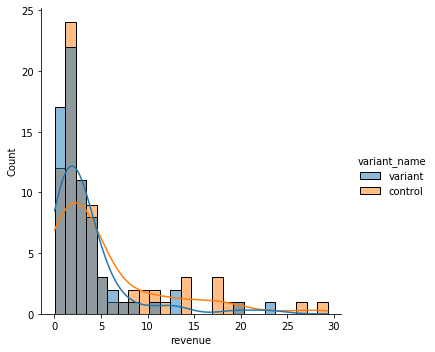

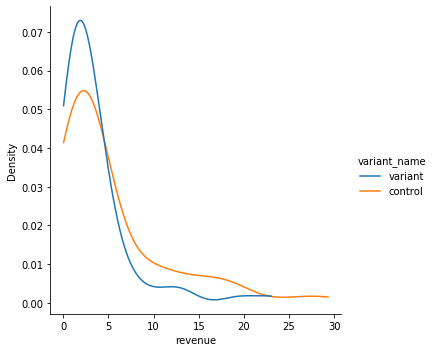

In [16]:
nz = df[df['revenue'] != 0.0]

# nz = nz[np.abs(nz.revenue-nz.revenue.mean()) <= (3*nz.revenue.std())]  # убираем выбросы так
nz = nz[np.abs(nz.revenue) <= 40] # или так

sns.displot(nz, x='revenue', hue='variant_name', kde = True)
sns.displot(nz, x='revenue', hue='variant_name', kind = 'kde', cut = 0)

In [4]:
df.groupby('variant_name').agg({'revenue': 'mean'})

,revenue
variant_name,
control,0.129013
variant,0.070070


In [5]:
nz.groupby('variant_name').agg({'revenue': ['mean', 'median']})

revenue       
                  mean median
variant_name                 
control       5.658101   2.93
variant       4.881528   2.17

In [6]:
diff_c = df[df['variant_name'] == 'control'].groupby('user_id').agg({'revenue': 'sum'})
diff_v = df[df['variant_name'] == 'variant'].groupby('user_id').agg({'revenue': 'sum'})

diffs = diff_c.rename(columns = {'revenue':'rev_c'}).join(diff_v, how = 'outer').dropna()
diffs['d'] = diffs['revenue'] - diffs['rev_c']

ttest_ind(diffs['rev_c'], diffs['revenue'])

#Проведённый T-тест не выявил значимой разницы между средними Revenue
#Посмотрим на разницу по количеству людей, использующих платные функции

Ttest_indResult(statistic=0.002847920571206357, pvalue=0.9977278756516494)

In [7]:
df['paid'] = (df['revenue'] != 0)

percents = df.groupby(['variant_name', 'paid']).agg({'paid':'count'})
percents


paid
variant_name paid       
control      False  4904
             True     80
variant      False  4944
             True     72

In [8]:
perc_c = percents.iloc[1] / (percents.iloc[1] + percents.iloc[0]) * 100
perc_v = percents.iloc[3] / (percents.iloc[3] + percents.iloc[2]) * 100

print(perc_v-perc_c)

paid   -0.16973
dtype: float64


In [9]:
cont_table = [[int(percents.iloc[0]), int(percents.iloc[2])], [int(percents.iloc[1]), int(percents.iloc[3])]]

cont_table

[[4904, 4944], [80, 72]]

In [10]:
t22 = sm.api.stats.Table2x2(cont_table)

print(t22.summary())

#Видно, что результирующий эффект -- неоднозначный. Количество пользователей, использующих платные функции,
# может как увеличиться, так и уменьшиться

               Estimate   SE   LCB    UCB  p-value
--------------------------------------------------
Odds ratio        0.893        0.648 1.230   0.488
Log odds ratio   -0.113 0.164 -0.434 0.207   0.488
Risk ratio        0.946        0.813 1.102   0.476
Log risk ratio   -0.055 0.078 -0.207 0.097   0.476
--------------------------------------------------
